**A discussion of your exploration of the dataset.**

The main file, `user_ratedmovies_train.dat`, includes movie and user ids and ratings of the movies, as well as a date and time for each. The average rating is 3.4, with 4 stars being the most common rating. There are very few films with less than two stars. As far as users go, the dataset contained just over 2000 unique users who gave a median of 244 reviews. Some users gave in the thousands of reviews, and all gave at least a dozen.

Mean Rating: 3.4381000210226342
Most Common Rating: 4.0


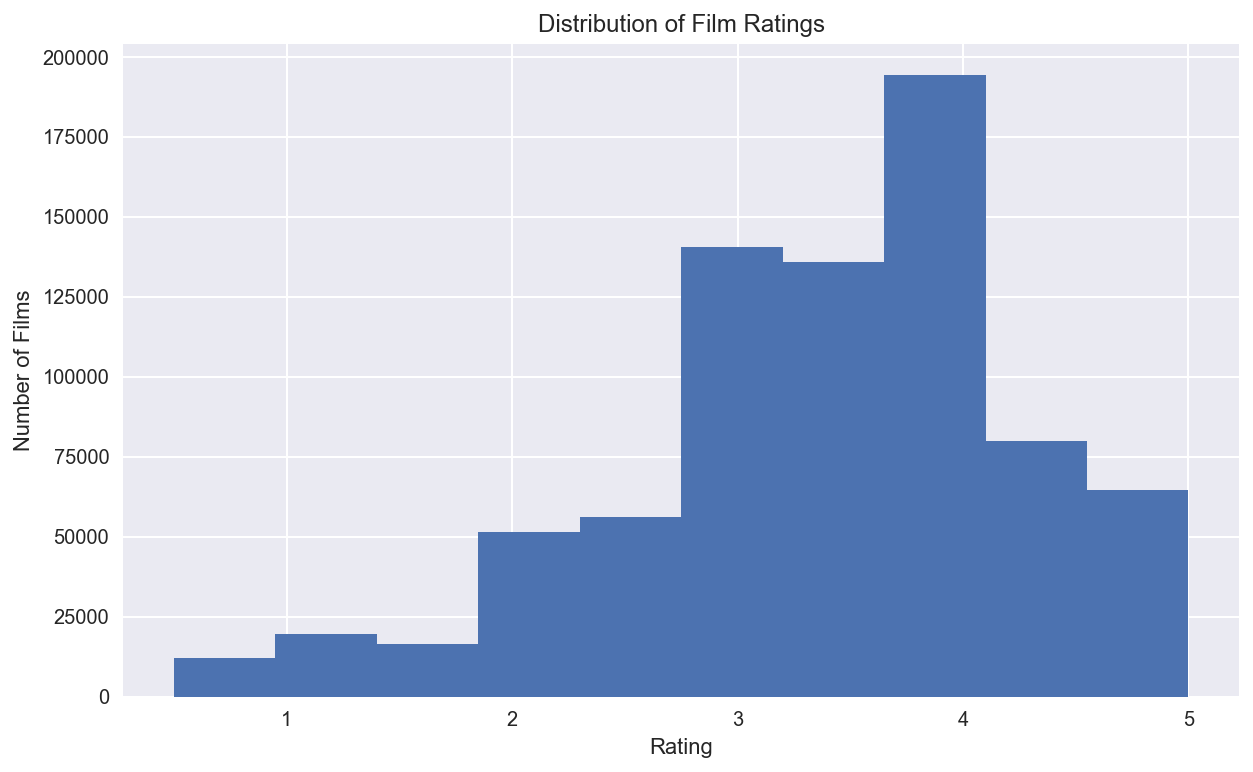

In [231]:
plt.hist(ur['rating'])
plt.ylabel('Number of Films')
plt.xlabel('Rating')
plt.title('Distribution of Film Ratings')
print('Mean Rating:', ur['rating'].mean())
print('Most Common Rating:', ur['rating'].mode()[0])

Median Number of Reviews: 244.0


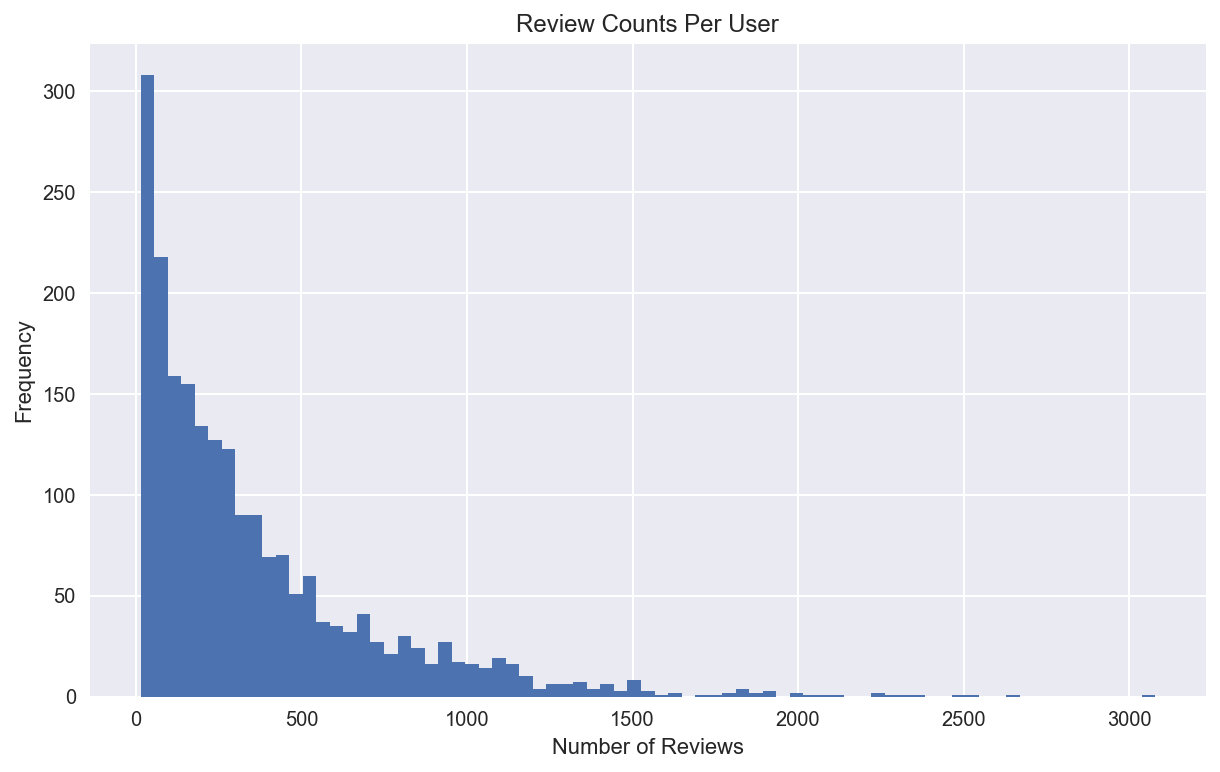

In [17]:
ur['userID'].value_counts().plot.hist(bins=75)
plt.title('Review Counts Per User')
plt.xlabel('Number of Reviews')
print('Median Number of Reviews:', ur['userID'].value_counts().median())

**A clear, technical description of your approach.**

For my approach, I used matrix factorization via stochastic gradient descent. This is the most common way for tackling this type of dataset, and is powerful as a collaborative filtering approach to recommendation systems. I could have opted for a content filtering approach since we have an expanded dataset with content information to work with, but went with matrix factorization for two reasons: 1) I have experience with more content-based approaches like naive bayes, but had none with matrix factorization, and wanted to have the learning experience. 2) Matrix factorization is a more genearlizable approach which, in a real way, _infers_ information about the content of the films based on the user data.

The model I used, matrix factorization, allows the matrix of rating information to be expanded into two vector matrices that contain encoded information about various factors of each film. Each vector entry can be thought of how much a film aligns with a particular factor, or how much a user enjoys that factor. When these vectors are multiplied, you get a prediction of that users rating of the film, even if that value was missing in the original matrix.

The model I used was stochastic gradient descent for matrix factorization. I used 40 factors (though I found that number to be suprisingly non-impactful on the results). I played with a variety of learning rates, regularization constants, and vector sizes, and found the best results to be $\eta = 0.2$, $\lambda = 0$, $K = 40$. I found that the regularization constant made my results far worse. Since I have no indication that I'm overfitting with my current approach (discussed below), I decided to exclude it altogether. I also found success in decaying my learning rate, as is common practice in SGD algorithms. To do so, I simply divided $\eta$ by 5 after every iteration. With $\eta = 0.2$ and no decay, I was able to achieve a RMSE of $.83$ on my validation set. After adding the decay, I was able to get it down to $.81$. In the graph of my loss below, you can see sudden periodic drops of loss where it is decayed. I trained for 3 iterations, as results did not improve after that point. I also found that adding a bias prevented the model from converging as efficiently as without (usually converging to around $.9$ RMSE).

To split into train/validation data, I simply used the code provided in the lab spec, which is about a 90/10 split. I used this validation set to evaluate my performance and check for overfitting.

**An analysis of how your approach worked on the dataset**

On my training set, it was $.79$. On my validation set it was $.81$. In fact, my training and validation losses were fairly close to one another throughout the training process. This is an encouraging result, as it indicates that my model is doing very little overfitting to the training set. Otherwise, the training loss would have been significantly smaller than the validation loss.

I went with the original algorithm, yes, but iterated implementation details and hyperparameters for improvements in performance. Adding the learning rate decay, for example, improved the model performance from a flat learning rate. I also iterated the way that the program handled the regularization and bias terms. Were this not a class project with limited available time, I would also try a content-filtering based approach and compare results or create an ensembling model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = (10.0, 6.0)
%config InlineBackend.figure_format = 'retina'

In [2]:
import pandas as pd
from tqdm import trange
from IPython.display import clear_output

In [3]:
ur = pd.read_csv('user_ratedmovies_train.dat','\t')
 
all_inds = np.random.permutation(range(0,len(ur)))
test_inds = all_inds[0:85000]
train_inds = all_inds[85000:len(ur)]
 
ur_test = ur.iloc[test_inds]
ur_train = ur.iloc[train_inds]

In [4]:
r = pd.DataFrame(data=0., columns=set(ur['userID']), index=set(ur['movieID']), dtype='float32')
for _, row in ur_train.iterrows():
    user = int(row['userID'])
    movie = int(row['movieID'])
    r.at[movie, user] = row['rating']

In [5]:
rank = 40
num_users = r.shape[1]
num_movies = r.shape[0]

In [6]:
user_ind_to_id = list(r.columns)
movie_ind_to_id = list(r.index)
user_id_to_ind = dict()
movie_id_to_ind = dict()
for i, val in enumerate(user_ind_to_id):
    user_id_to_ind[val] = i
for i, val in enumerate(movie_ind_to_id):
    movie_id_to_ind[val] = i

In [7]:
def rmse(prediction, truth):
    return np.sqrt(np.mean(np.square(prediction - truth)))

In [8]:
def evaluate(pred, test):
    err = []
    for _, row in ur_test.iterrows():
        user = user_id_to_ind[int(row['userID'])]
        movie = movie_id_to_ind[int(row['movieID'])]
        rating = row['rating']
        err.append(np.square(pred[movie, user] - rating))
    return np.sqrt(np.mean(np.array(err)))

In [9]:
lr = .02
lam = 0.
p = np.zeros((rank, num_users)) + np.sqrt(3. / rank)
q = np.zeros((num_movies, rank)) + np.sqrt(3. / rank)
bu = np.zeros((num_users,)) 
bi = np.zeros((num_movies,)) 
mu = 0.
losses = []
train_losses = []
count = 0

for e in range(3):
    train_errs = []
    for _, row in ur_train.iterrows():
        user = user_id_to_ind[int(row['userID'])]
        movie = movie_id_to_ind[int(row['movieID'])]
        rating = row['rating']
        
        reg = (1 - lr * lam)
        pred = q[movie,:].dot(p[:,user])
        rho = lr * (rating - mu - bi[movie] - bu[user] - pred)
        p[:, user] = reg * p[:, user] + q[movie, :] * rho
        q[movie, :] = reg * q[movie, :] + p[:, user] * rho
        train_errs.append(np.square(rating - pred))
        
        if count % 50000 == 0:
            losses.append(evaluate(q.dot(p), ur_test))
            train_losses.append(np.sqrt(np.mean(np.array(train_errs[-50000:]))))
            print('train loss: {}, eval loss: {}'.format(train_losses[-1], losses[-1]))
        count += 1
    lr /= 5
    print('Learning Rate decayed to {}'.format(lr))

train loss: 1.5000000000000013, eval loss: 1.094621817742655
train loss: 0.9203940180848715, eval loss: 0.8754643977203427
train loss: 0.8663265937234056, eval loss: 0.8572314271376241
train loss: 0.8554384038025128, eval loss: 0.8500121693491842
train loss: 0.8525680518320399, eval loss: 0.8458216783511132
train loss: 0.845902185168812, eval loss: 0.8428382900307902
train loss: 0.8385771937001634, eval loss: 0.8400522609460752
train loss: 0.8442639560872188, eval loss: 0.8388017342741122
train loss: 0.8374546347220381, eval loss: 0.8404831201098596
train loss: 0.8396501907342605, eval loss: 0.8372856812273803
train loss: 0.843658121329372, eval loss: 0.8362568143554734
train loss: 0.8380207539804229, eval loss: 0.83870404832022
train loss: 0.8417475993346155, eval loss: 0.8346313384580152
train loss: 0.8365622350379026, eval loss: 0.8377242639942659
Learning Rate decayed to 0.004
train loss: 0.8283812664616178, eval loss: 0.8325214572307292
train loss: 0.8240173180250834, eval loss: 0

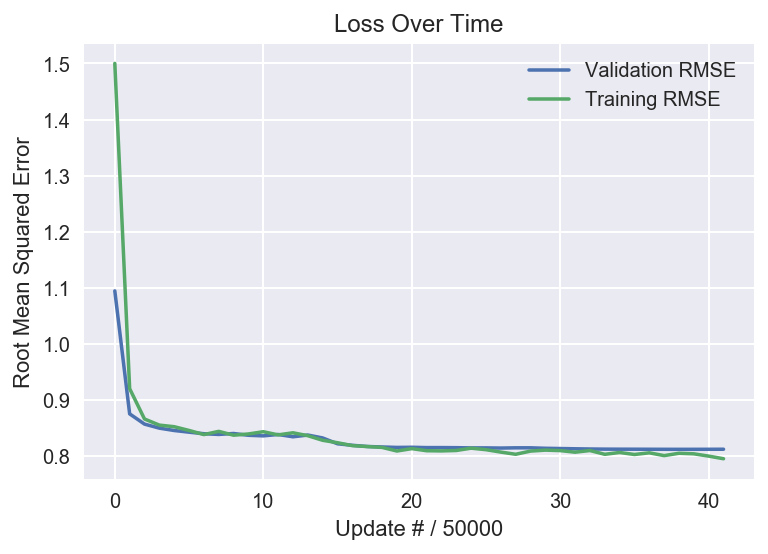

In [10]:
plt.plot(losses, label='Validation RMSE')
plt.plot(train_losses, label='Training RMSE')
plt.legend()
plt.title('Loss Over Time')
plt.xlabel('Update # / 50000')
plt.ylabel('Root Mean Squared Error')
plt.show()

In [11]:
rounded = np.round(q.dot(p) * 2, decimals=0) / 2.
print('Sample of Predictions Matrix:\n', rounded[:10, :10])

Sample of Predictions Matrix:
 [[3.5 4.  3.5 4.  3.5 4.  4.  3.5 4.  3.5]
 [2.5 3.  3.  3.  3.  3.5 3.5 3.  3.  3. ]
 [2.5 3.  2.5 3.  3.  3.5 3.  3.  3.  3. ]
 [3.  3.5 3.5 3.5 3.5 4.  4.  3.5 4.  3.5]
 [2.5 3.  3.  3.  3.  3.5 3.  3.  3.  3. ]
 [3.5 4.  3.5 4.  4.  4.5 4.5 4.  4.  4. ]
 [3.  3.5 3.  3.5 3.  3.5 3.5 3.  3.5 3. ]
 [2.5 3.  2.5 3.  2.5 3.  3.  2.5 3.  2.5]
 [2.5 3.  2.5 3.  3.  3.  3.  3.  3.  3. ]
 [3.  3.5 3.  3.5 3.5 4.  3.5 3.  3.5 3.5]]


In [63]:
for _, row in pred.iterrows():
    if row.movieID not in movie_id_to_ind.keys():
        movie_id_to_ind[row.movieID] = -1

In [64]:
pred = pd.read_csv('predictions.dat','\t')
pred_users = [user_id_to_ind[id] for id in pred.userID]
pred_movies = [movie_id_to_ind[id] for id in pred.movieID]
pred['predicted rating'] = q.dot(p)[pred_movies,pred_users]

In [87]:
mypred = pred.drop(columns=['userID', 'movieID'])
mypred = mypred.set_index('testID')

In [94]:
mypred.index = mypred.index.map(int)

In [95]:
mypred.head()

,predicted rating
testID,
0,3.861637
1,3.435613
2,3.205198
3,4.439334
4,3.883044


In [96]:
mypred.to_csv('my_predictions.csv', sep='\t')